In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from bayes_opt import BayesianOptimization
import tensorflow as tf
from tensorflow import keras

# 导入训练集和测试集
train_data = pd.read_excel(r'C:\Users\k\Desktop\硕士论文\ORP\ORP4\ORP_function_train.xlsx')
test_data = pd.read_excel(r'C:\Users\k\Desktop\硕士论文\ORP\ORP4\ORP_function_test.xlsx')

# 分离特征和目标变量
X_train, y_train = train_data.drop(['E','File'], axis=1), train_data['E']
X_test, y_test = test_data.drop(['E','File'], axis=1), test_data['E']

# 定义神经网络模型
def build_model(learning_rate, dropout_rate, l2_reg):
    model = keras.Sequential([
        keras.layers.Input(shape=(X_train.shape[1],)),
        keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(l2_reg)),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(l2_reg)),
        keras.layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# 定义贝叶斯优化目标函数
def bayesian_optimization(learning_rate, dropout_rate, l2_reg):
    kf = KFold(random_state=99, shuffle=True, n_splits=10)
    total_rmse = 0.0
    for train_index, val_index in kf.split(X_train):
        model = build_model(learning_rate, dropout_rate, l2_reg)
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
        model.fit(X_train_fold, y_train_fold, epochs=2000, batch_size=20, verbose=0)
        y_val_pred = model.predict(X_val_fold)
        fold_rmse = np.sqrt(mean_squared_error(y_val_fold, y_val_pred))
        total_rmse += fold_rmse
    return -total_rmse / 5  # 返回平均RMSE的负值

# 设置贝叶斯优化的搜索范围
param_bounds = {'learning_rate': (0.001, 0.1), 'dropout_rate': (0.1, 0.5), 'l2_reg': (0.0001, 0.1)}

# 初始化贝叶斯优化对象
optimizer = BayesianOptimization(f=bayesian_optimization, pbounds=param_bounds, random_state=1)

# 运行贝叶斯优化
optimizer.maximize(init_points=5, n_iter=10)

# 输出最佳超参数
best_params = optimizer.max['params']
print("Best Hyperparameters:", best_params)

# 使用最佳超参数构建最终模型
best_model = build_model(best_params['learning_rate'], best_params['dropout_rate'], best_params['l2_reg'])

# 重新进行5折交叉验证来获取最优模型的RMSE
kf = KFold(random_state=99, shuffle=True, n_splits=10)
rmses = []
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    best_model.fit(X_train_fold, y_train_fold, epochs=2000, batch_size=20, verbose=0)
    y_val_pred = best_model.predict(X_val_fold)
    fold_rmse = np.sqrt(mean_squared_error(y_val_fold, y_val_pred))
    rmses.append(fold_rmse)

print(f"10折交叉验证的RMSE: {rmses}")

# 使用最终模型进行预测和评估
best_model.fit(X_train, y_train, epochs=2000, batch_size=20, verbose=1)
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"训练集RMSE: {train_rmse}, 训练集R2: {train_r2}")
print(f"测试集RMSE: {test_rmse}, 测试集R2: {test_r2}")

# 计算MAPE
mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
print(f'MAPE (Training): {mape_train}')
print(f'MAPE (Testing): {mape_test}')



|   iter    |  target   | dropou... |  l2_reg   | learni... |
-------------------------------------------------------------


1/1 [==============================] - 0s 44ms/step
| 1         | -0.8229   | 0.2668    | 0.07206   | 0.001011  |
1/1 [==============================] - 0s 44ms/step
| 2         | -0.7955   | 0.2209    | 0.01476   | 0.01014   |
1/1 [==============================] - 0s 43ms/step
| 3         | -0.9613   | 0.1745    | 0.03462   | 0.04028   |
1/1 [==============================] - 0s 44ms/step
| 4         | -0.887    | 0.3155    | 0.04198   | 0.06884   |
1/1 [==============================] - 0s 43ms/step
| 5         | -0.7996   | 0.1818    | 0.08782   | 0.003711  |
1/1 [==============================] - 0s 46ms/step
| 6         | -0.8812   | 0.2503    | 0.07901   | 0.07767   |
1/1 [==============================] - 0s 44ms/step
| 7         | -0.8396   | 0.3129    | 0.07876   | 0.01832   |
1/1 [==============================] - 0s 44ms/step
| 8         | -0.967   

1/1 [==============================] - 0s 44ms/step
| 10        | -0.8119   | 0.3905    | 0.07289   | 0.02027   |
1/1 [==============================] - 0s 42ms/step
| 11        | -0.8873   | 0.2881    | 0.04241   | 0.04772   |
1/1 [==============================] - 0s 44ms/step
| 12        | -0.82     | 0.1811    | 0.08747   | 0.001301  |
1/1 [==============================] - 0s 46ms/step
| 13        | -0.9832   | 0.2955    | 0.08413   | 0.09793   |
1/1 [==============================] - 0s 45ms/step
| 14        | -1.108    | 0.229     | 0.07638   | 0.08584   |
1/1 [==============================] - 0s 44ms/step
| 15        | -1.021    | 0.442     | 0.07196   | 0.09129   |
Best Hyperparameters: {'dropout_rate': 0.22093302905273593, 'l2_reg': 0.014760913492629592, 'learning_rate': 0.010141520882110983}
1/1 [==============================] - 0s 17ms/step
10折交叉验证的RMSE: [0.40694732932976946, 0.37727599928043853, 0.4295976419460622, 0.32818271230547064, 0.359186723956349, 0.31584918339578

9/9 [==============================] - 0s 1ms/step - loss: 0.0480
Epoch 50/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0524
Epoch 51/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0593
Epoch 52/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0516
Epoch 53/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0606
Epoch 54/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0523
Epoch 55/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0553
Epoch 56/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0508
Epoch 57/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0457
Epoch 58/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0550
Epoch 59/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0609
Epoch 60/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0542
Epoch 61/2000
9/9 [==============================] - 0

Epoch 151/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0419
Epoch 152/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0474
Epoch 153/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0481
Epoch 154/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0434
Epoch 155/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0501
Epoch 156/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0472
Epoch 157/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0547
Epoch 158/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0478
Epoch 159/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0485
Epoch 160/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0546
Epoch 161/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0480
Epoch 162/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0449
Epoch 163/2000
9/9 [========

9/9 [==============================] - 0s 1ms/step - loss: 0.0454
Epoch 253/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0500
Epoch 254/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0441
Epoch 255/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0497
Epoch 256/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0522
Epoch 257/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0730
Epoch 258/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0635
Epoch 259/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0478
Epoch 260/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0490
Epoch 261/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0535
Epoch 262/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0450
Epoch 263/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0491
Epoch 264/2000
9/9 [=======================

9/9 [==============================] - 0s 1ms/step - loss: 0.0622
Epoch 354/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0477
Epoch 355/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0442
Epoch 356/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0504
Epoch 357/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0530
Epoch 358/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0515
Epoch 359/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0433
Epoch 360/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0523
Epoch 361/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0615
Epoch 362/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0722
Epoch 363/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0441
Epoch 364/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0542
Epoch 365/2000
9/9 [=======================

9/9 [==============================] - 0s 1ms/step - loss: 0.0453
Epoch 455/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0436
Epoch 456/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0493
Epoch 457/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0418
Epoch 458/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0475
Epoch 459/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0452
Epoch 460/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0512
Epoch 461/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0526
Epoch 462/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0497
Epoch 463/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0595
Epoch 464/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0670
Epoch 465/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0491
Epoch 466/2000
9/9 [=======================

9/9 [==============================] - 0s 1ms/step - loss: 0.0461
Epoch 556/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0473
Epoch 557/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0606
Epoch 558/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0500
Epoch 559/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0430
Epoch 560/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0441
Epoch 561/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0428
Epoch 562/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0455
Epoch 563/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0463
Epoch 564/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0563
Epoch 565/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0508
Epoch 566/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0543
Epoch 567/2000
9/9 [=======================

9/9 [==============================] - 0s 1ms/step - loss: 0.0537
Epoch 657/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0665
Epoch 658/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0484
Epoch 659/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0423
Epoch 660/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0505
Epoch 661/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0482
Epoch 662/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0481
Epoch 663/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0497
Epoch 664/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0422
Epoch 665/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0460
Epoch 666/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0664
Epoch 667/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0496
Epoch 668/2000
9/9 [=======================

9/9 [==============================] - 0s 1ms/step - loss: 0.0468
Epoch 758/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0782
Epoch 759/2000
9/9 [==============================] - 0s 2ms/step - loss: 0.0449
Epoch 760/2000
9/9 [==============================] - 0s 2ms/step - loss: 0.0472
Epoch 761/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0478
Epoch 762/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0466
Epoch 763/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0475
Epoch 764/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0523
Epoch 765/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0580
Epoch 766/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0449
Epoch 767/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0488
Epoch 768/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0433
Epoch 769/2000
9/9 [=======================

9/9 [==============================] - 0s 1ms/step - loss: 0.0472
Epoch 859/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0524
Epoch 860/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0509
Epoch 861/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0617
Epoch 862/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0458
Epoch 863/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0447
Epoch 864/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0444
Epoch 865/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0456
Epoch 866/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0425
Epoch 867/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0409
Epoch 868/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0502
Epoch 869/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0476
Epoch 870/2000
9/9 [=======================

9/9 [==============================] - 0s 1ms/step - loss: 0.0564
Epoch 960/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0460
Epoch 961/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0498
Epoch 962/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0780
Epoch 963/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0561
Epoch 964/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0508
Epoch 965/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0489
Epoch 966/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0449
Epoch 967/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0563
Epoch 968/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0607
Epoch 969/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0561
Epoch 970/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0502
Epoch 971/2000
9/9 [=======================

9/9 [==============================] - 0s 1ms/step - loss: 0.0493
Epoch 1060/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0481
Epoch 1061/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0414
Epoch 1062/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0489
Epoch 1063/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0473
Epoch 1064/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0585
Epoch 1065/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0490
Epoch 1066/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0923
Epoch 1067/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0489
Epoch 1068/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0506
Epoch 1069/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0494
Epoch 1070/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0549
Epoch 1071/2000
9/9 [===========

9/9 [==============================] - 0s 2ms/step - loss: 0.0452
Epoch 1160/2000
9/9 [==============================] - 0s 2ms/step - loss: 0.0643
Epoch 1161/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0414
Epoch 1162/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0458
Epoch 1163/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0451
Epoch 1164/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0443
Epoch 1165/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0486
Epoch 1166/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0449
Epoch 1167/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0463
Epoch 1168/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0482
Epoch 1169/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0523
Epoch 1170/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0531
Epoch 1171/2000
9/9 [===========

9/9 [==============================] - 0s 1ms/step - loss: 0.0563
Epoch 1260/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0518
Epoch 1261/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0460
Epoch 1262/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0464
Epoch 1263/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0457
Epoch 1264/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0469
Epoch 1265/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0431
Epoch 1266/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0448
Epoch 1267/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0477
Epoch 1268/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0637
Epoch 1269/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0437
Epoch 1270/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0560
Epoch 1271/2000
9/9 [===========

9/9 [==============================] - 0s 1ms/step - loss: 0.0478
Epoch 1360/2000
9/9 [==============================] - 0s 3ms/step - loss: 0.0504
Epoch 1361/2000
9/9 [==============================] - 0s 2ms/step - loss: 0.0460
Epoch 1362/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0633
Epoch 1363/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0579
Epoch 1364/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0433
Epoch 1365/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0445
Epoch 1366/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0580
Epoch 1367/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0455
Epoch 1368/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0435
Epoch 1369/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0421
Epoch 1370/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0473
Epoch 1371/2000
9/9 [===========

9/9 [==============================] - 0s 1ms/step - loss: 0.0652
Epoch 1460/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0435
Epoch 1461/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0472
Epoch 1462/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0515
Epoch 1463/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0465
Epoch 1464/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0463
Epoch 1465/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0447
Epoch 1466/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0498
Epoch 1467/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0554
Epoch 1468/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0490
Epoch 1469/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0475
Epoch 1470/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0426
Epoch 1471/2000
9/9 [===========

9/9 [==============================] - 0s 1ms/step - loss: 0.0456
Epoch 1560/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0513
Epoch 1561/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0710
Epoch 1562/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0448
Epoch 1563/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0572
Epoch 1564/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0451
Epoch 1565/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0524
Epoch 1566/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0685
Epoch 1567/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0573
Epoch 1568/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0478
Epoch 1569/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0442
Epoch 1570/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0477
Epoch 1571/2000
9/9 [===========

9/9 [==============================] - 0s 1ms/step - loss: 0.0455
Epoch 1660/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0472
Epoch 1661/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0468
Epoch 1662/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0559
Epoch 1663/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0462
Epoch 1664/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0457
Epoch 1665/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0459
Epoch 1666/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0515
Epoch 1667/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0462
Epoch 1668/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0458
Epoch 1669/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0614
Epoch 1670/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0524
Epoch 1671/2000
9/9 [===========

9/9 [==============================] - 0s 1ms/step - loss: 0.0446
Epoch 1760/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0642
Epoch 1761/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0531
Epoch 1762/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0441
Epoch 1763/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0447
Epoch 1764/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0503
Epoch 1765/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0520
Epoch 1766/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0543
Epoch 1767/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0467
Epoch 1768/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0520
Epoch 1769/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0507
Epoch 1770/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0456
Epoch 1771/2000
9/9 [===========

9/9 [==============================] - 0s 1ms/step - loss: 0.0460
Epoch 1860/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0508
Epoch 1861/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0517
Epoch 1862/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0430
Epoch 1863/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0531
Epoch 1864/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0611
Epoch 1865/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0490
Epoch 1866/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0428
Epoch 1867/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0439
Epoch 1868/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0424
Epoch 1869/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0489
Epoch 1870/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0483
Epoch 1871/2000
9/9 [===========

9/9 [==============================] - 0s 1ms/step - loss: 0.0464
Epoch 1960/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0424
Epoch 1961/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0494
Epoch 1962/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0569
Epoch 1963/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0529
Epoch 1964/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0671
Epoch 1965/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0476
Epoch 1966/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0559
Epoch 1967/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0503
Epoch 1968/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0423
Epoch 1969/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0483
Epoch 1970/2000
9/9 [==============================] - 0s 1ms/step - loss: 0.0542
Epoch 1971/2000
9/9 [===========

In [3]:
print(f"10折交叉验证的RMSE: {rmses}")

10折交叉验证的RMSE: [0.40694732932976946, 0.37727599928043853, 0.4295976419460622, 0.32818271230547064, 0.359186723956349, 0.3158491833957883, 0.38709175580837957, 0.2751377559423159, 0.4467016432710971, 0.35135676402852856]


7/7 [==============================] - 0s 1ms/step


Using 217 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/217 [00:00<?, ?it/s]

14309/14309 [==============================] - 11s 788us/step


14309/14309 [==============================] - 11s 767us/step


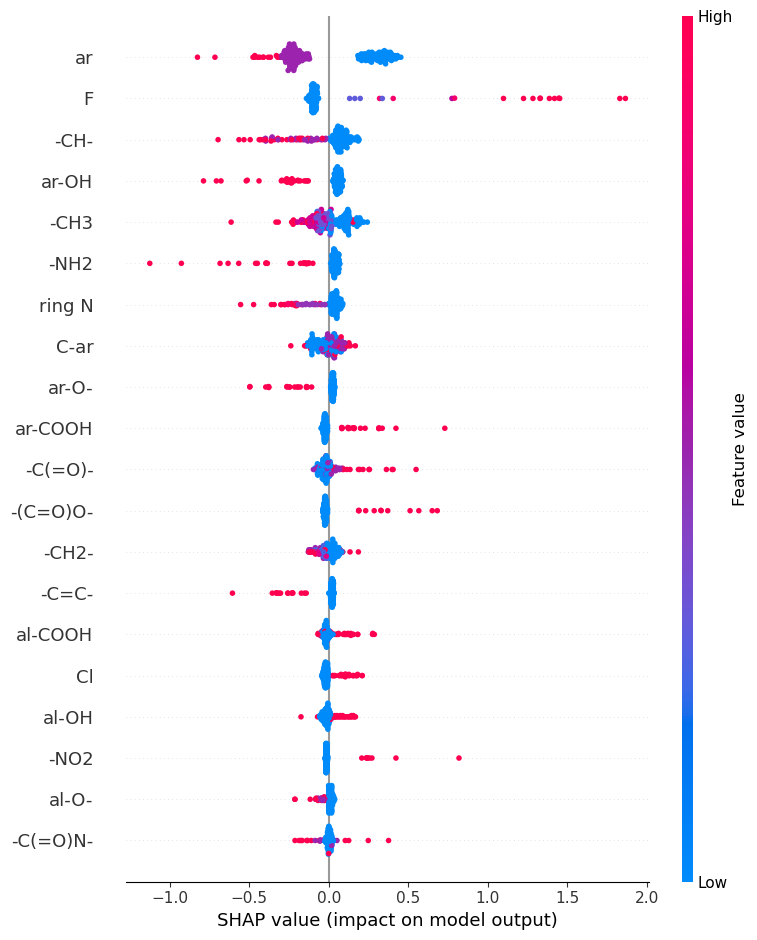

In [10]:
import shap

data = pd.concat([X_train, X_test])
# 为了使用KernelExplainer，需要一个预测函数
def f(X):
    return best_model.predict(X).flatten()

# 使用KernelExplainer
explainer = shap.KernelExplainer(f,data)  # 使用X_train的样本作为背景数据集
shap_values = explainer.shap_values(data)  # 对X_test的样本计算SHAP值

# 可视化第一个预测的SHAP值
shap.initjs()  # 用于在Jupyter笔记本中显示图形
#shap.force_plot(explainer.expected_value, shap_values[0], shap.sample(X_test, 100).iloc[0])

# 查看特征的总体重要性
shap.summary_plot(shap_values, data)


  0%|          | 0/217 [00:00<?, ?it/s]

14309/14309 [==============================] - 11s 761us/step


14309/14309 [==============================] - 11s 755us/step


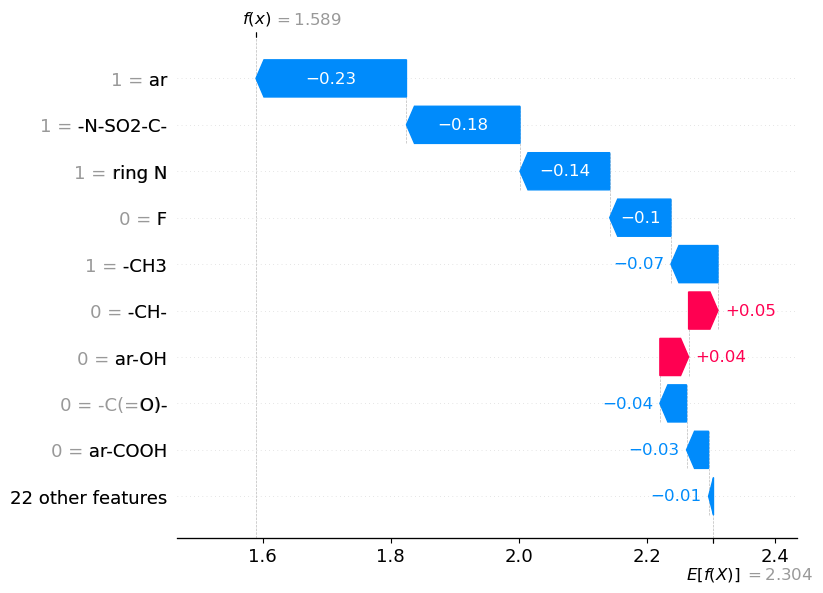

In [18]:

shap_values1 = explainer(data)

# 显示可视化图
shap.plots.waterfall(shap_values1[158])


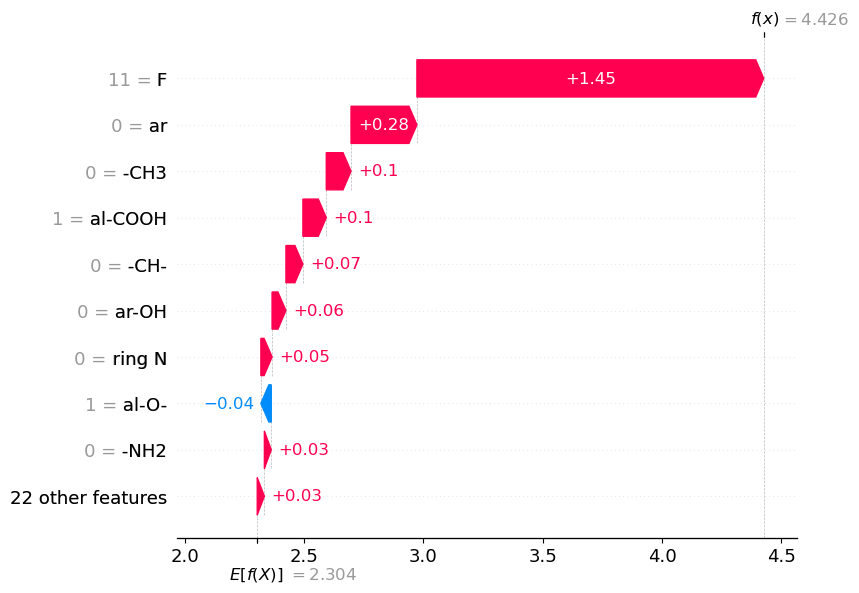

In [19]:
# 显示可视化图
shap.plots.waterfall(shap_values1[162])

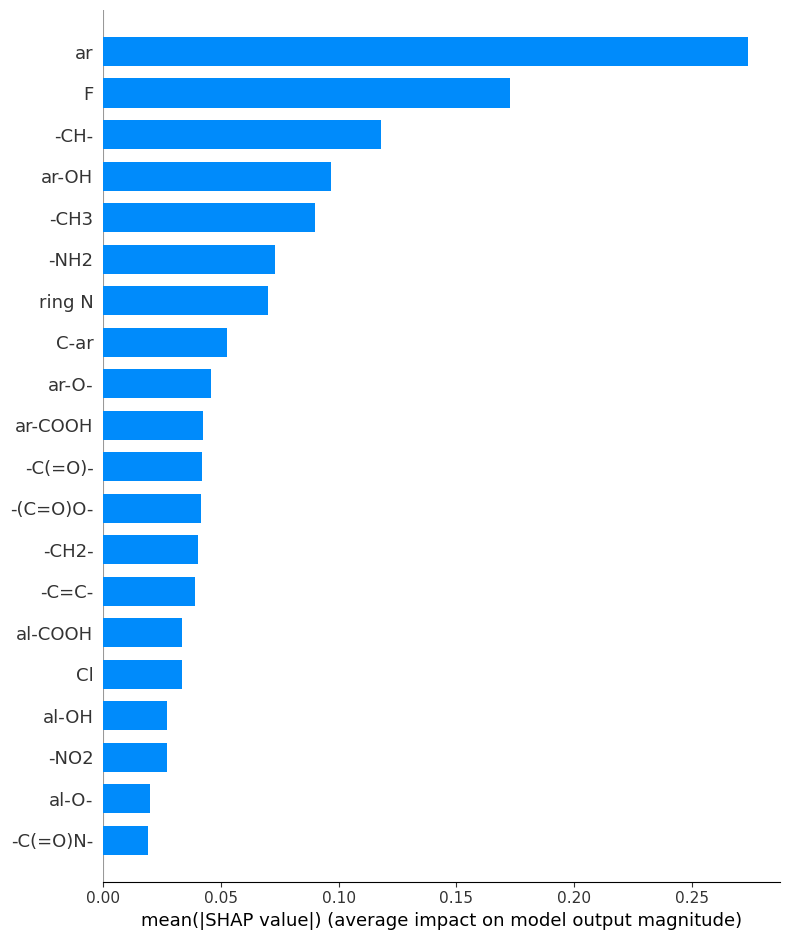

In [20]:
shap.summary_plot(shap_values,data, plot_type="bar")

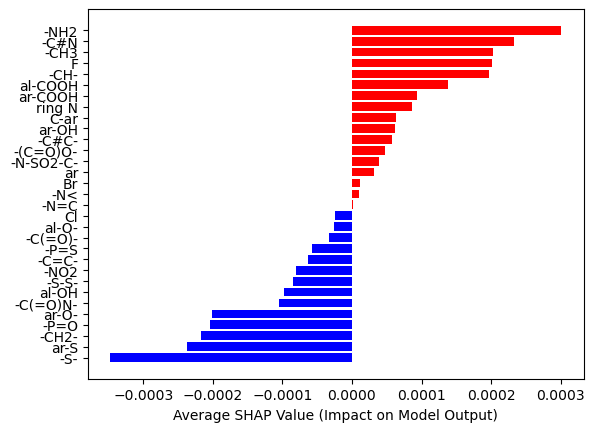

In [29]:

import matplotlib.pyplot as plt
# 计算每个特征的平均SHAP值
shap_sum = shap_values.mean(axis=0)
shap_sum_abs = np.abs(shap_values).mean(axis=0)
shap_sum
# 对特征进行排序
feature_indices = np.argsort(shap_sum)

# 绘制条形图
plt.barh(range(len(shap_sum)), shap_sum[feature_indices], color=['red' if s > 0 else 'blue' for s in shap_sum[feature_indices]])
plt.yticks(range(len(shap_sum)), np.array(data.columns)[feature_indices])
plt.xlabel('Average SHAP Value (Impact on Model Output)')
plt.show()


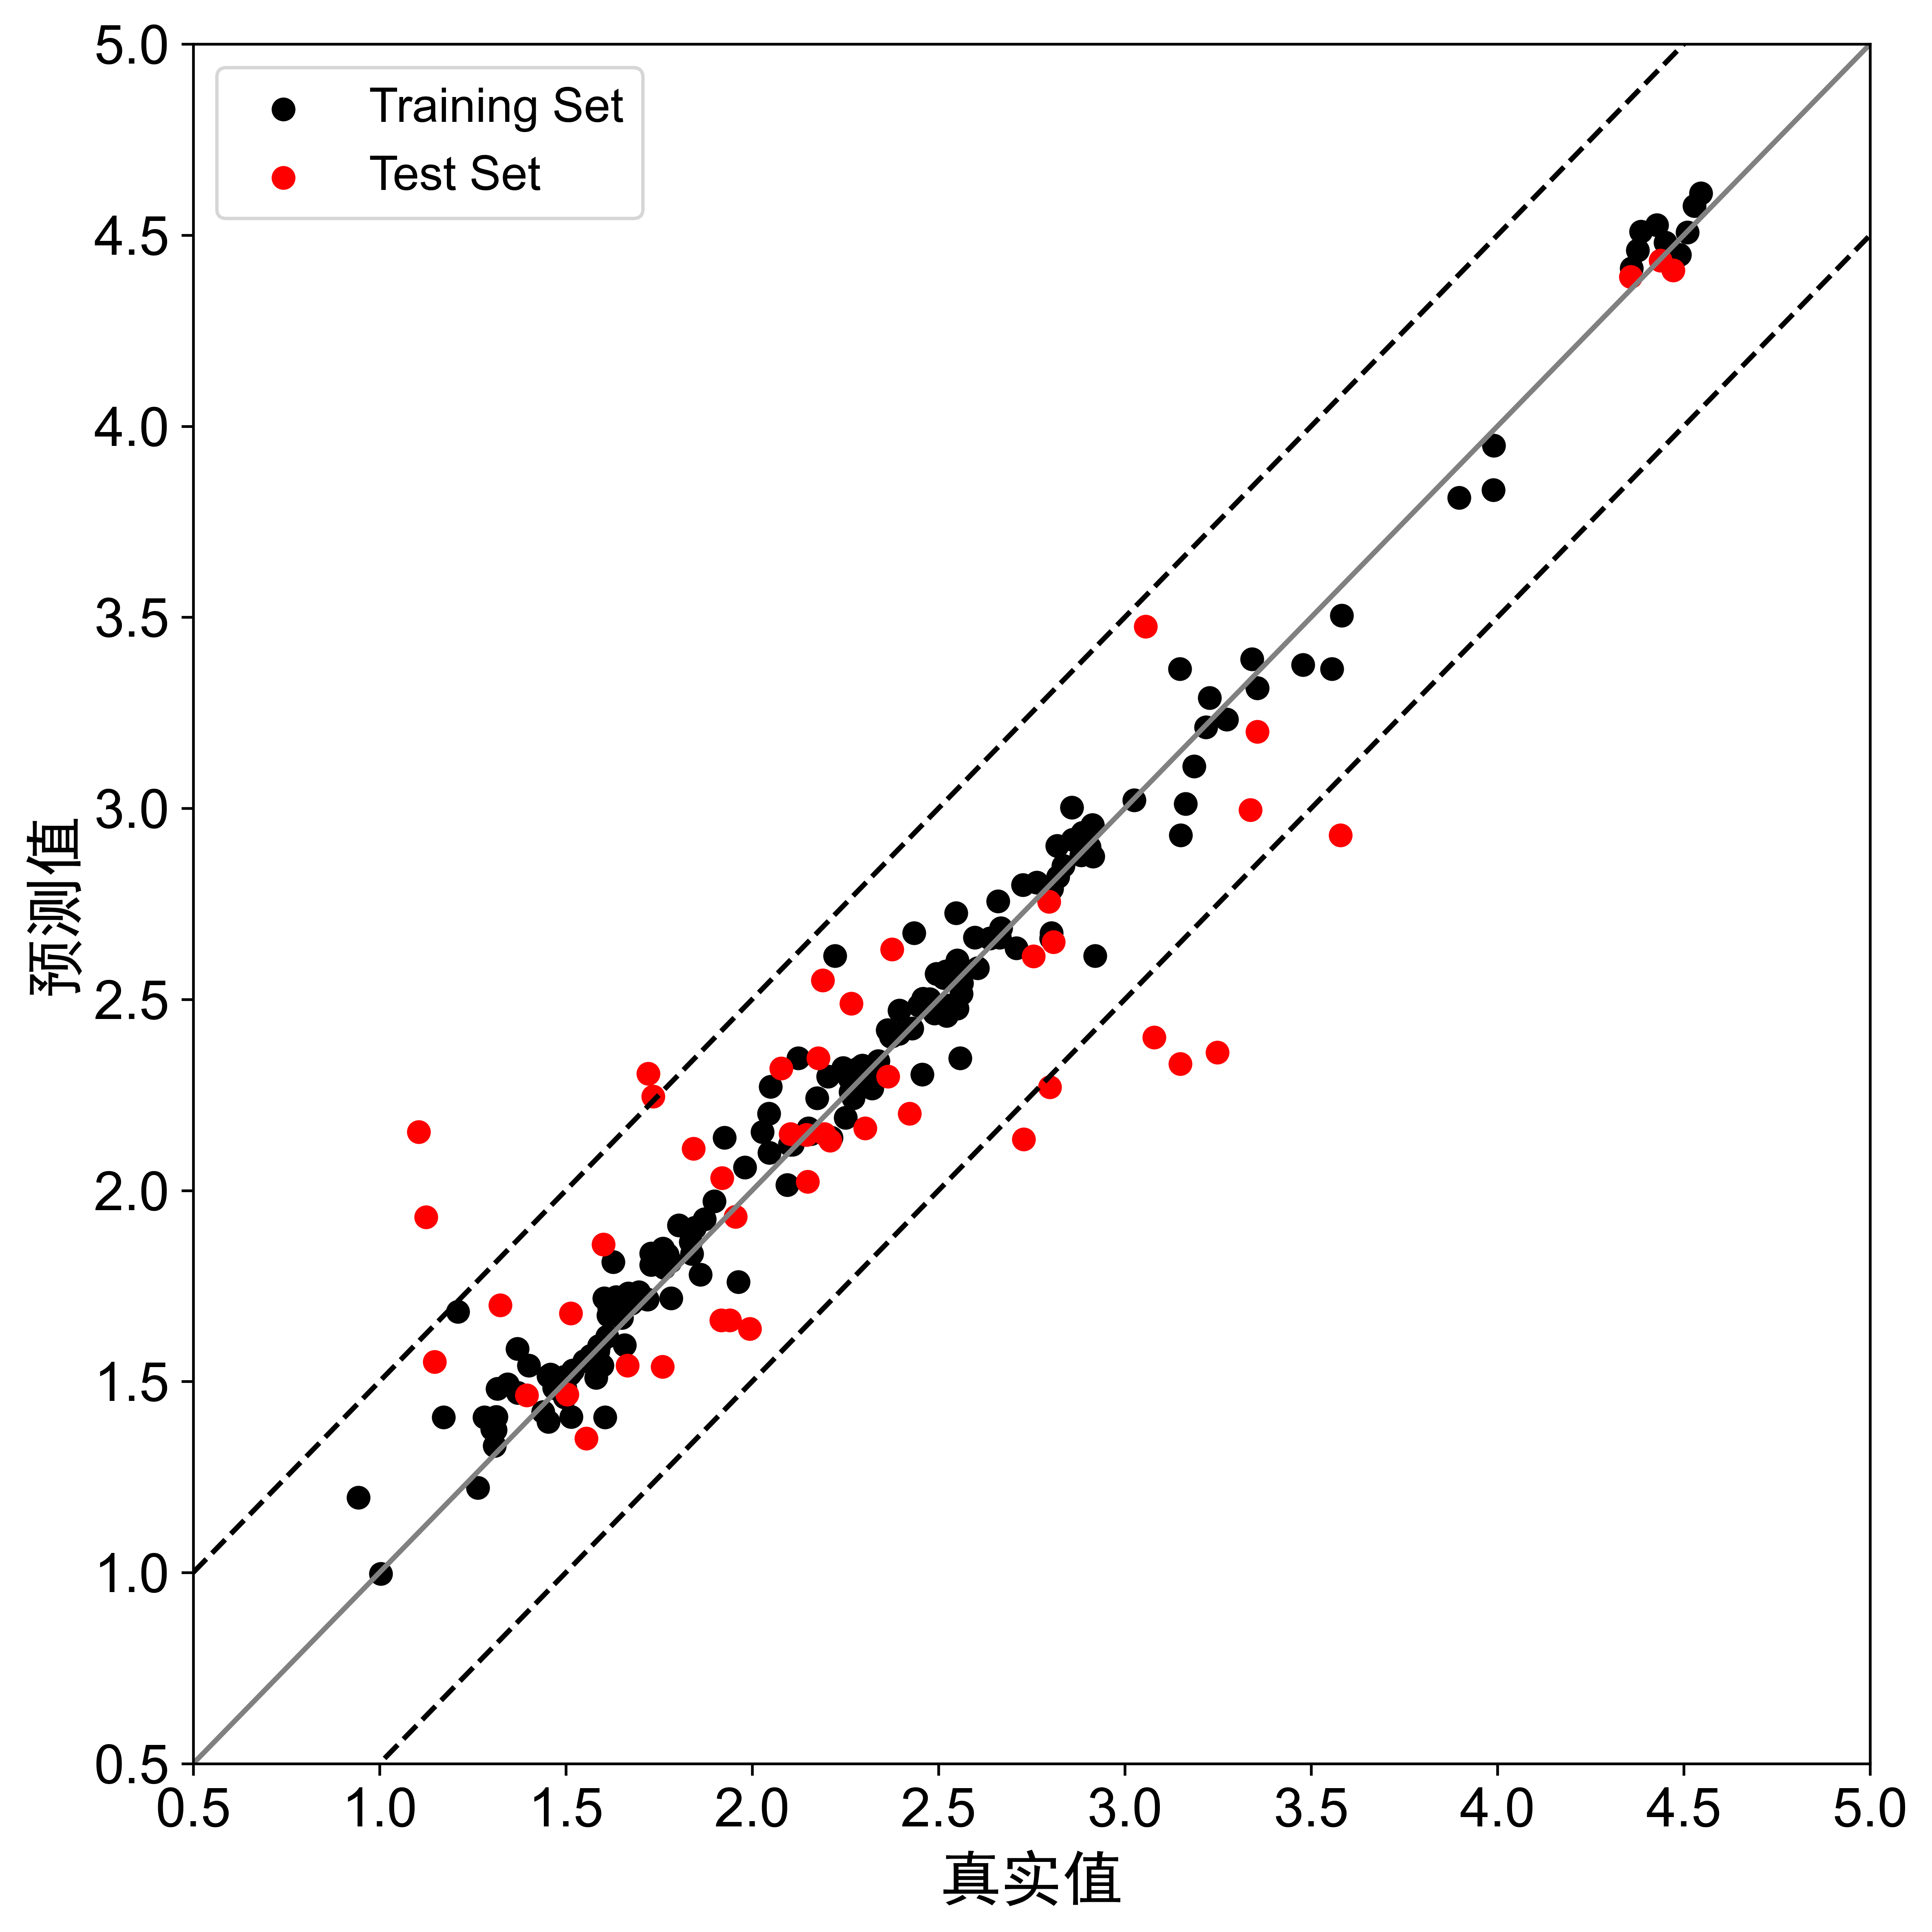

In [5]:
import matplotlib.pyplot as plt

# 绘制训练集和测试集的预测值与实际值对比图
plt.figure(figsize=(8, 8))
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['figure.dpi']=600
# 训练集
plt.scatter(y_train, y_train_pred, label='Training Set', color='black')

# 测试集
plt.scatter(y_test, y_test_pred, label='Test Set', color='red')

# 对角线表示完美预测的情况
plt.plot([0.5, 5], [0.5, 5], '-', color='gray')
plt.plot([0.5, 5], [0.5 - 0.5, 5 - 0.5], linestyle='--', color='black')
plt.plot([0.5, 5], [0.5 + 0.5, 5 + 0.5], linestyle='--', color='black')
plt.xlim(0.5, 5)
plt.ylim(0.5, 5)
plt.xlabel('真实值',fontsize=18)
plt.ylabel('预测值',fontsize=18)
plt.yticks(fontproperties = 'Arial', size = 16)
plt.xticks(fontproperties = 'Arial', size = 16)
bwith = 5 #边框宽度设置为2
plt.legend(prop={'family' : 'Arial', 'size'   : 14})
#plt.rcParams['font.family'] = ['Arial']
plt.tight_layout()
plt.show()
